In [1]:
import os
import cv2
import glob
import shutil
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import imgaug.augmenters as iaa
import imgaug as aug
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from collections import defaultdict, Counter

In [2]:
seed=1234
np.random.seed(seed)
color=sns.color_palette()
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload 
%autoreload 2

In [3]:
# Define some paths for future use
input_path = Path("../data")
train_dir = input_path / "train_data"
test_dir = input_path / "test_data"

In [4]:
# Load the train csv file
train_df = pd.read_csv("../CSVs/train.csv")
print("Number of training samples: ", len(train_df))

Number of training samples:  31072


In [5]:
train_df["nb_labels"] = train_df["Target"].apply(lambda x: len(x.split(" ")))
print(f"Maximum number of labels attached to a single sample: {train_df['nb_labels'].max()}")
print(f"Minimum number of labels attached to a single sample: {train_df['nb_labels'].min()}")
print("All counts:")
print(train_df["nb_labels"].value_counts())

Maximum number of labels attached to a single sample: 5
Minimum number of labels attached to a single sample: 1
All counts:
1    15126
2    12485
3     3160
4      299
5        2
Name: nb_labels, dtype: int64


In [6]:
# Labelmap

labels_dict={
0:  "Nucleoplasm", 
1:  "Nuclear membrane",   
2:  "Nucleoli",   
3:  "Nucleoli fibrillar center" ,  
4:  "Nuclear speckles"   ,
5:  "Nuclear bodies"   ,
6:  "Endoplasmic reticulum",   
7:  "Golgi apparatus"   ,
8:  "Peroxisomes"   ,
9:  "Endosomes"   ,
10:  "Lysosomes"   ,
11:  "Intermediate filaments",   
12:  "Actin filaments"   ,
13:  "Focal adhesion sites",   
14:  "Microtubules"   ,
15:  "Microtubule ends",   
16:  "Cytokinetic bridge",   
17:  "Mitotic spindle"   ,
18:  "Microtubule organizing center" ,  
19:  "Centrosome"   ,
20:  "Lipid droplets",   
21:  "Plasma membrane",   
22:  "Cell junctions"  , 
23:  "Mitochondria"   ,
24:  "Aggresome"   ,
25:  "Cytosol",
26:  "Cytoplasmic bodies",   
27:  "Rods & rings" 
}

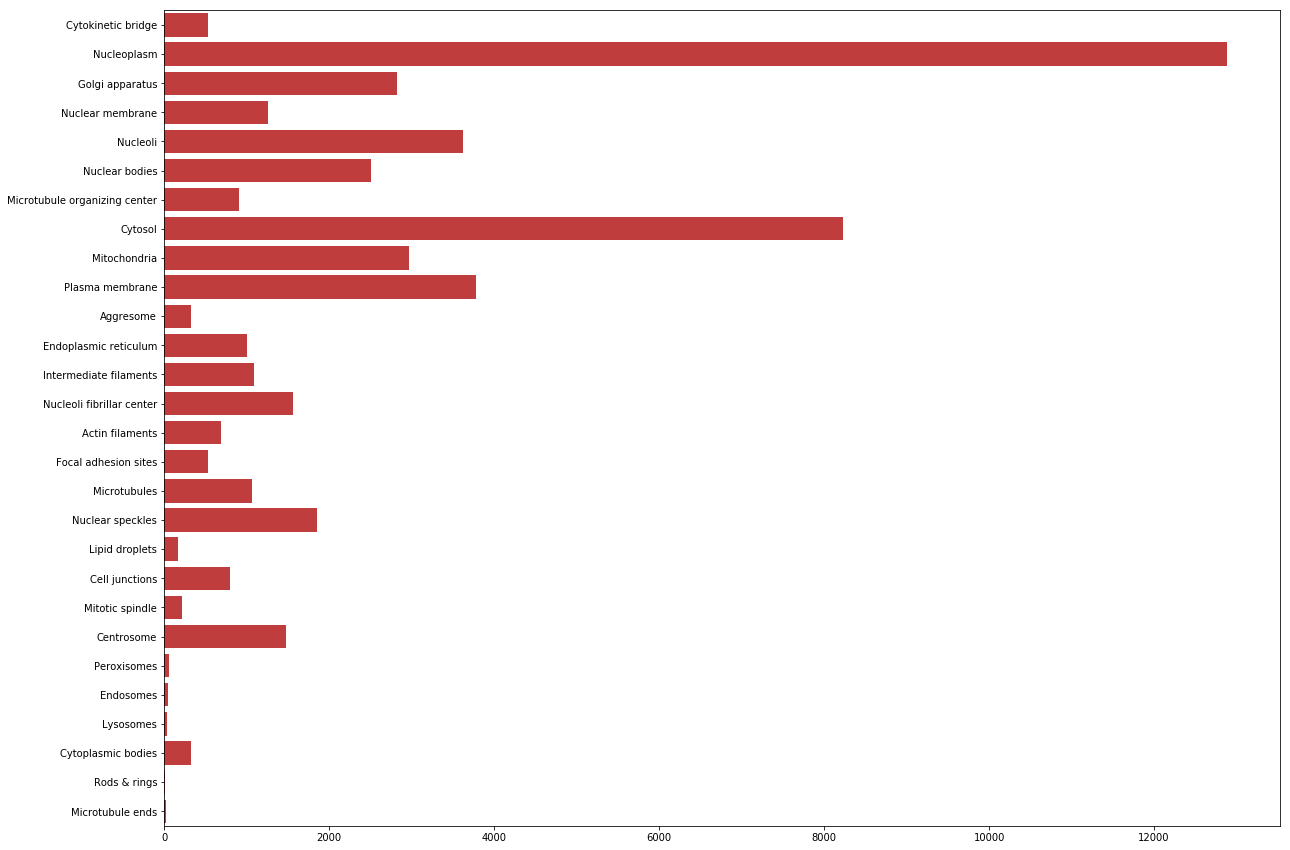

In [7]:
# Split the labels
labels = train_df["Target"].apply(lambda x: x.split(" "))

# Create a counter. This initializes the count for each class with a value of zero
labels_count = defaultdict(int)

# Update the counter 
for label in labels:
    if len(labels) > 1:
        for l in label:
            labels_count[labels_dict[int(l)]]+=1
    else:
        labels_count[labels_dict[int(label)]]+=1

# Plot         
plt.figure(figsize=(20,15))
sns.barplot(x=list(labels_count.values()), y=list(labels_count.keys()), color=color[3], orient='h')
plt.show()

In [11]:
train_df["labels"] = [list(map(int, i.split())) for i in train_df['Target']]
train_df.head()

,Id,Target,nb_labels,labels
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0,2,"[16, 0]"
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0,4,"[7, 1, 2, 0]"
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5,1,[5]
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1,1,[1]
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18,1,[18]


In [12]:
def count_labels(df_labels, plot=False, figsize=(20,10), title=None, xlabel=None, ylabel=None):
    sample_labels_count = Counter()
    
    # Update the counter 
    for label in df_labels:
        for l in label:
            sample_labels_count[labels_dict[l]]+=1
    
    # Plot 
    if plot:
        plt.figure(figsize=(20,15))
        sns.barplot(x=list(sample_labels_count.values()), y=list(sample_labels_count.keys()), color=color[3], orient='h')
        if title:
            plt.title(title, fontsize=14)
        if xlabel:
            plt.xlabel(xlabel, fontsize=14)
        if ylabel:
            plt.ylabel(ylabel, fontsize=14)
        plt.show()
    
    return sample_labels_count

In [13]:
# Check the distribution for different label counts in each sample
single_labels_df = train_df[(train_df['nb_labels']==1)]['labels']
single_labels_count = count_labels(single_labels_df)

double_labels_df = train_df[(train_df['nb_labels']==2)]['labels']
double_labels_count = count_labels(double_labels_df)

In [14]:
single_labels_count

Counter({'Nuclear bodies': 983,
         'Nuclear membrane': 271,
         'Microtubule organizing center': 314,
         'Nucleoplasm': 2414,
         'Golgi apparatus': 1163,
         'Mitochondria': 1653,
         'Plasma membrane': 1058,
         'Cytosol': 1470,
         'Intermediate filaments': 601,
         'Focal adhesion sites': 157,
         'Actin filaments': 232,
         'Nucleoli': 808,
         'Lipid droplets': 98,
         'Nucleoli fibrillar center': 654,
         'Microtubules': 484,
         'Centrosome': 522,
         'Endoplasmic reticulum': 622,
         'Nuclear speckles': 1077,
         'Cytoplasmic bodies': 134,
         'Cell junctions': 213,
         'Peroxisomes': 31,
         'Aggresome': 122,
         'Cytokinetic bridge': 27,
         'Endosomes': 17,
         'Rods & rings': 1})

In [15]:
double_labels_count

Counter({'Cytokinetic bridge': 189,
         'Nucleoplasm': 7737,
         'Cytosol': 4645,
         'Nucleoli': 1840,
         'Aggresome': 159,
         'Endoplasmic reticulum': 286,
         'Intermediate filaments': 347,
         'Nucleoli fibrillar center': 678,
         'Actin filaments': 269,
         'Nuclear speckles': 642,
         'Mitochondria': 1016,
         'Nuclear membrane': 629,
         'Microtubule organizing center': 396,
         'Nuclear bodies': 1133,
         'Plasma membrane': 1815,
         'Cell junctions': 397,
         'Golgi apparatus': 1139,
         'Centrosome': 679,
         'Peroxisomes': 19,
         'Lipid droplets': 50,
         'Microtubules': 406,
         'Cytoplasmic bodies': 147,
         'Mitotic spindle': 81,
         'Focal adhesion sites': 230,
         'Endosomes': 17,
         'Lysosomes': 17,
         'Rods & rings': 4,
         'Microtubule ends': 3})

Total number of examples where there is only one label 15126
Minimum number of samples for a single class:  1
Maximum number of samples for a single class:  2414
Labels Percentile:  484.0


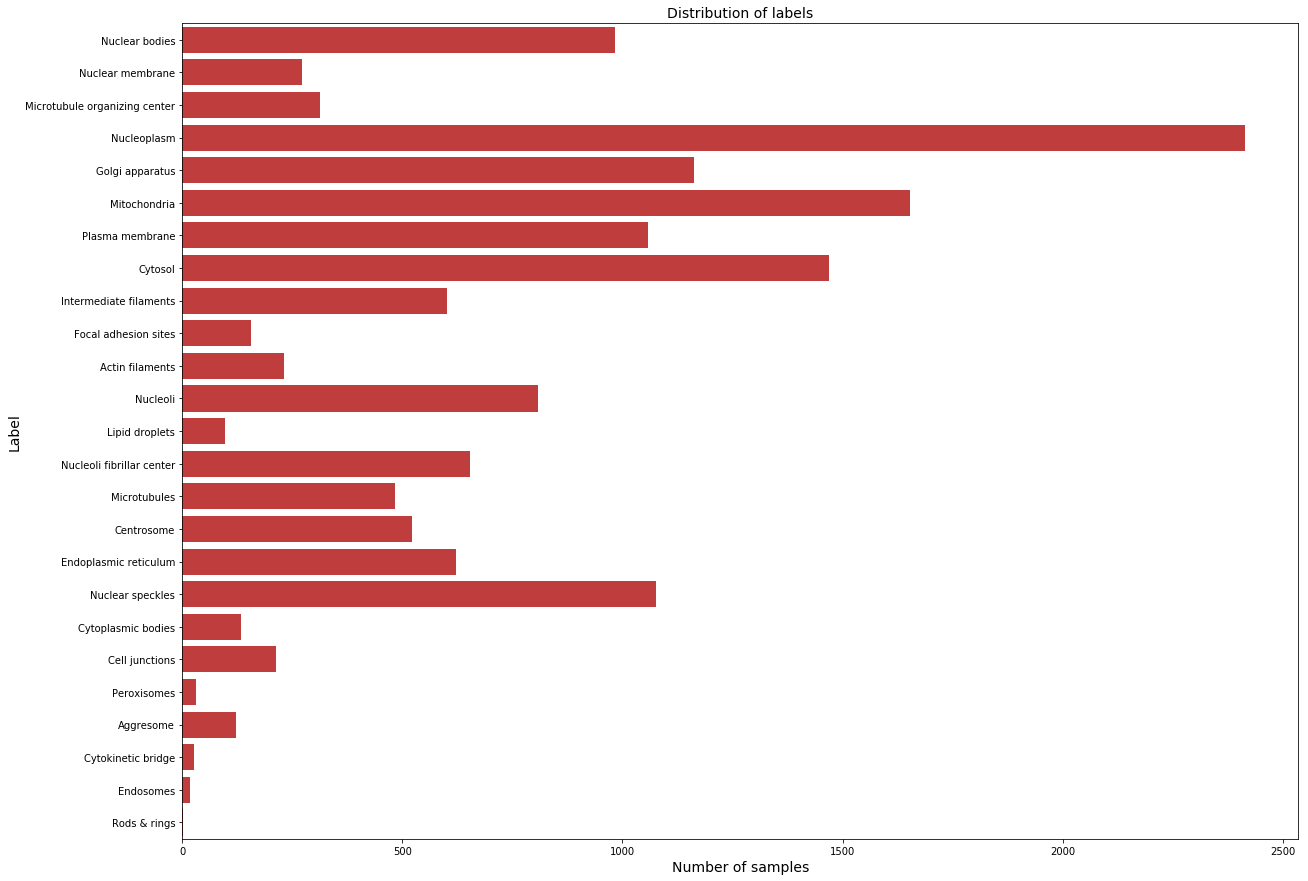

In [26]:
single_labels_arr = np.array(list(single_labels_count.values()), dtype=np.int32)
print("Total number of examples where there is only one label", len(single_labels_df))
print("Minimum number of samples for a single class: ", single_labels_arr.min())
print("Maximum number of samples for a single class: ", single_labels_arr.max())
print("Labels Percentile: ", np.percentile(single_labels_arr, q=50))

_ = count_labels(single_labels_df,title="Distribution of labels",
                 xlabel="Number of samples", 
                 ylabel="Label", plot=True)

Total number of examples where there is only one label 12485
Minimum number of samples for a single class:  3
Maximum number of samples for a single class:  7737
Labels Percentile:  371.5


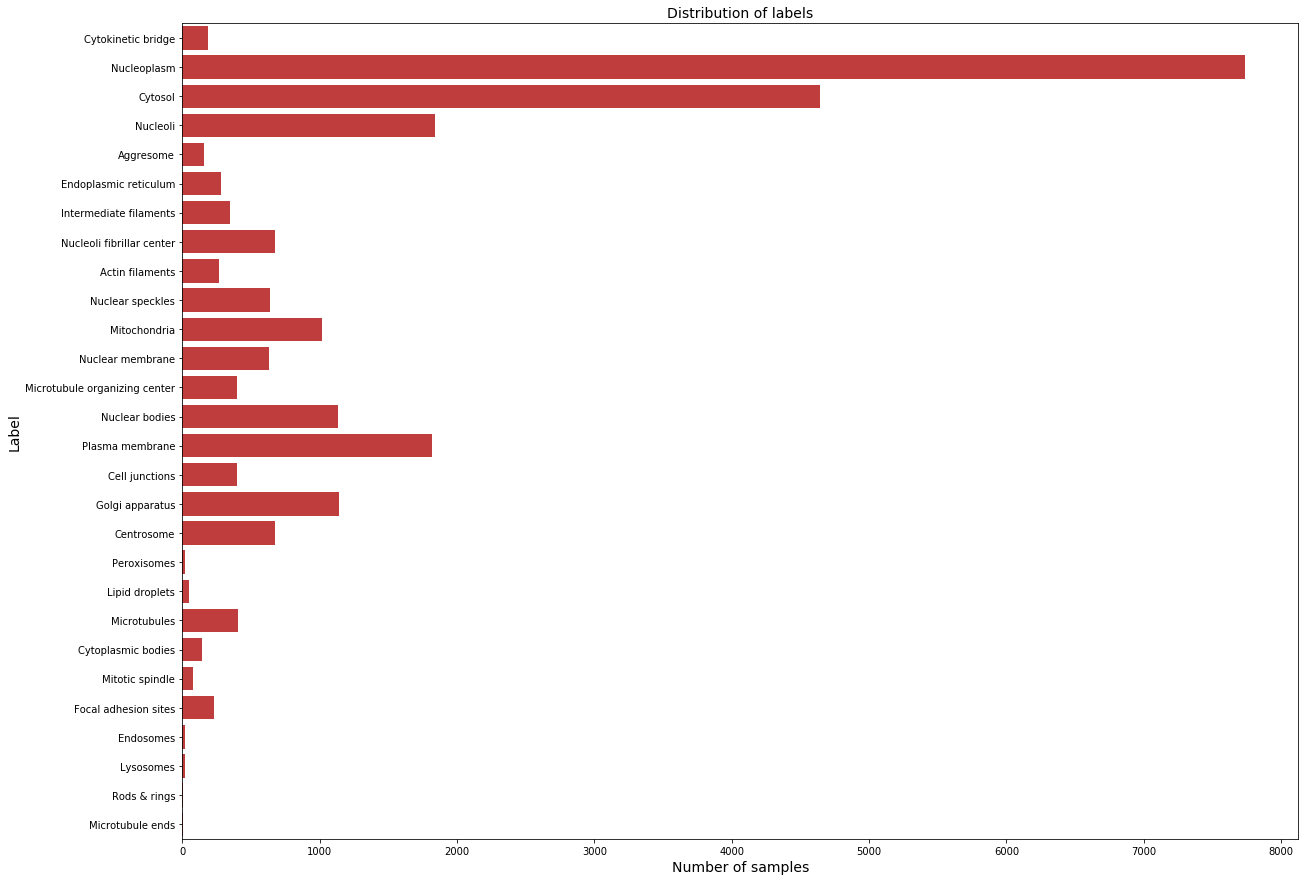

In [27]:
double_labels_arr = np.array(list(double_labels_count.values()), dtype=np.int32)
print("Total number of examples where there is only one label", len(double_labels_df))
print("Minimum number of samples for a single class: ", double_labels_arr.min())
print("Maximum number of samples for a single class: ", double_labels_arr.max())
print("Labels Percentile: ", np.percentile(double_labels_arr, q=50))

_ = count_labels(double_labels_df,title="Distribution of labels",
                 xlabel="Number of samples", 
                 ylabel="Label", plot=True)

In [29]:
# Check which labels are not in single and double category
all_labels = set(labels_dict.values())
single_labels = set(single_labels_count.keys())
double_labels = set(double_labels_count.keys())

print("Labels which don't appear alone in the dataset: ", all_labels-single_labels)
print("Labels which don't appear with another label in a pair of two in the dataset: ", all_labels-double_labels)

Labels which don't appear alone in the dataset:  {'Lysosomes', 'Microtubule ends', 'Mitotic spindle'}
Labels which don't appear with another label in a pair of two in the dataset:  set()



* So, there is no training example where there is a sole sample for classes: 'Lysosomes', 'Microtubule ends', 'Mitotic spindle'
* Also, every label appears in the dataset in a pair or with more than two labels